<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *DATA SCIENCE / SECTION 2 / SPRINT 2 / NOTE 3*

---
# Evaluation Metrics for Classification

- **Confusion matrix** 를 만들고 해석할 수 있습니다.
- **정밀도, 재현율** 을 이해하고 사용할 수 있습니다.
- **ROC curve, AUC 점수** 를 이해하고 사용할 수 있습니다.

### Warm up

다음 동영상을 시청하고 질문에 답해보세요.
- [Introduction to the Confusion Matrix in Classification](https://youtu.be/wpp3VfzgNcI)
- [Precision, Recall & F-Measure](https://youtu.be/j-EB6RqqjGI)
    - 동영상에 F beta 공식은 잘못 적혀 있습니다 주의하세요. 그리고 b를 키우면 recall의 영향을 더 많이 받습니다.
    - Precision, Recall의 차이점이 무엇일까요?
    - 암 진단을 위해서는 어떤 지표가 더 중요할까요? 예시를 들어 생각해 보세요!


---

#### 계절독감 접종여부를 타겟 데이터로 사용하겠습니다.

In [1]:
import pandas as pd
import numpy as np

In [2]:
# 이번에는 타겟으로 계절독감백신 접종여부를 사용하겠습니다.

target = 'vacc_seas_f'
train = pd.merge(pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train.csv'), 
                 pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train_labels.csv')[target], left_index=True, right_index=True)
# 테스트 데이터 수를 n=14052 로 한정합니다.
test = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/test.csv').iloc[:14052]
sample_submission = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/submission.csv')

#### train 데이터를 훈련/검증 세트로 분리합니다.

In [3]:
from sklearn.model_selection import train_test_split

# 검증세트를 테스트세트와 크기와 같도록 만듭니다.
train, val = train_test_split(train, test_size=len(test), 
                              stratify=train[target], random_state=2)


train.shape, val.shape, test.shape

((28102, 39), (14052, 39), (14052, 38))

이전 강의에서와 같이 데이터를 전처리 합니다.

In [4]:
def engineer(df):
    """특성을 엔지니어링 하는 함수입니다."""
        
    # 새로운 특성을 생성합니다.
    behaviorals = [col for col in df.columns if 'behavioral' in col] 
    df['behaviorals'] = df[behaviorals].sum(axis=1)
    
    
    # 계절독감(seas)에 대한 모델을 학습할 것이기 때문에 h1n1에 대한 특성을 제거합니다.
    dels = [col for col in df.columns if ('employment' in col or 'h1n1' in col)]
    df.drop(columns=dels, inplace=True)

        
    return df


train = engineer(train)
val = engineer(val)
test = engineer(test)

#### 훈련/검증/테스트 데이터를 특성과 타겟으로 분리합니다

In [5]:
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

#### 모델을 학습시키겠습니다.

In [6]:
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 파이프라인을 만들어 봅시다.
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)
)


pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
print('검증 정확도: ', accuracy_score(y_val, y_pred))

검증 정확도:  0.7548391688015941


## 분류 모델의 성능 평가 지표를 보여주는 Confusion matrix 에 관해 살펴봅시다.

#### sklearn.metrics.plot_confusion_matrix를 사용해 봅시다.

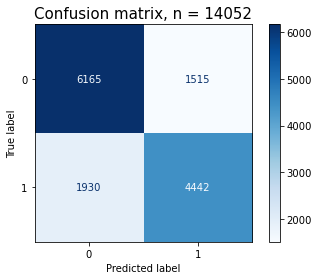

In [7]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()

#### plot_confusion_matrix 에서 테이블 데이터만 가져와 총 정확도(accuracy)를 구해봅시다.

In [8]:
cm = pcm.confusion_matrix
cm

array([[6165, 1515],
       [1930, 4442]])

- True Positive(TP) 백신을 맞은 사람을 잘 예측한 경우

In [9]:
# 예측:functional, 실제:functional
cm[1][1]

4442

- 정확하게 맞춘 예측은 모두 몇 가지인가요? (TP + TN)

In [10]:
correct_predictions = np.diag(cm).sum()
correct_predictions

10607

- 총 예측한 수는 어떻게 되나요?

In [11]:
total_predictions = cm.sum()
total_predictions

14052

- 분류 정확도(classification accuracy)를 계산해 보세요

In [12]:
correct_predictions/total_predictions

0.7548391688015941

`accuracy_score(y_val, y_pred)`로 계산한 `검증 정확도`와 같은 값이 나오네요.

In [13]:
print('검증 정확도: ', accuracy_score(y_val, y_pred))

검증 정확도:  0.7548391688015941


#### 분류기의 정확한 성능을 판단하기 위해서는 정확도 외에 다른 평가지표를 같이 사용해야 합니다.

특히 **정밀도(precision)**, **재현율(recall)** 을 살펴보아야 합니다.

[Scikit-Learn User Guide — Classification Report](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report)

- 정확도(Accuracy)는 전체 범주를 모두 바르게 맞춘 경우를 전체 수로 나눈 값입니다: $\large \frac{TP + TN}{Total}$

- 정밀도(Precision)는 **Positive로 예측**한 경우 중 올바르게 Positive를 맞춘 비율입니다: $\large \frac{TP}{TP + FP}$

- 재현율(Recall, Sensitivity)은 **실제 Positive**인 것 중 올바르게 Positive를 맞춘 것의 비율 입니다: $\large \frac{TP}{TP + FN}$

- F1점수(F1 score)는 정밀도와 재현율의 조화평균(harmonic mean)입니다:  $ 2\cdot\large\frac{precision\cdot recall}{precision + recall}$

<img src="https://i.imgur.com/4tes8Au.png" />

#### 다루는 문제에 따라 정밀도와 재현율 중 어느 평가지표를 우선시 해야하는지 판단해야 합니다.
- 병원에서 초기 암진단을 하는 경우?
- 넷플릭스에서 영화추천을 해주는 경우?



sklearn.metrics.classification_report 를 사용하면 정밀도, 재현율을 확인할 수 있습니다.

In [14]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.80      0.78      7680
           1       0.75      0.70      0.72      6372

    accuracy                           0.75     14052
   macro avg       0.75      0.75      0.75     14052
weighted avg       0.75      0.75      0.75     14052



#### 이제 정밀도과 재현율을 직접 계산해 봅시다. 참고를 위해 confusion_matrix를 다시 불러오겠습니다.

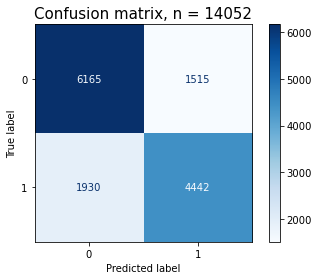

In [15]:
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()

#### 백신접종을 Positive라고 할 때 TP, TN, FP, FN 를 정의합시다.

In [16]:
tp = 4442
tn = 6165
fp = 1515
fn = 1930
total = tp + tn + fp + fn

#### 백신 접종을 올바르게 예측한 경우는?

In [17]:
tp

4442

#### 백신 접종을 잘못 예측한 경우는?

In [18]:
fp

1515

#### 백신 접종에 대해 정밀도를 구해봅시다.

In [19]:
positives = tp + fp
tp/positives

0.7456773543730065

#### 실제 백신 접종한 경우는 얼마나 됩니까?

In [20]:
real_positives = tp + fn
real_positives

6372

#### 백신 접종에 대해 재현율을 구해봅시다.

In [21]:
tp / real_positives

0.697112366603892

## 정밀도, 재현율, 임계값(thresholds), 예측확률간 관계를 살펴볼 수 있는 간단한 시나리오를 살펴보겠습니다.

#### 시나리오는 다음과 같습니다.

코로나로 인해 전 세계가 몸살을 앓고 있는 시점에, 세계보건기구는 전체 인구의 70%가 코로나 항체를 가지고 있으면 '집단 면역'이 형성돼 코로나 유행을 멈출 수 있다고 보고하였습니다.

마침, 용인시 양지면에서는 지역 주민들에게 계절독감에 대한 무료 접종을 준비하고 있었습니다.(코로나가 아닙니다) 계절독감 백신을 주민들에게 효율적으로 접종하기 위한 논의를 하던 중 무료접종에 대한 설계를 잘 하면 주민들 사이에 집단 면역을 생성해 계절독감 free 지역이 될 수 있을것 같다는 의견이 나왔습니다.

양지면 인구는 (가상으로)14052명입니다. 이번 겨울 이들 모두 항체가 없다고 가정했을 때 이들 중 70%가 백신을 접종한다면 양지면은 집단면역을 형성할 수 있을것 같습니다!


In [22]:
# 양지면에서 집단면역을 위한 백신 접종 수
herdImmunity = total * 0.7
herdImmunity

9836.4

#### 양지면 집단 면역을 위해서는 자율적으로 접종하는 사람들 외에 더 많은 사람이 접종하여야 합니다.
다행히 병원에 계절독감 백신은 충분히 유통되어 개인적으로 접종하는 사람들이 꽤 되었습니다(real_positivs = tp + fn)

In [23]:
# 집단면역을 위해 추가 접종이 필요한 인원
herdImmunity - real_positives

3464.3999999999996

양지면에서는 무료백신 예산이 한정되어 있어 4500여명에게만 무료 백신을 미리 접종할 수 있다고 합니다.(무료백신에 지원에 대한 사회적 불평등과 여러 복잡한 상황에 대한 이슈는 뒤로합시다..)

어떻게 하면 개인적으로 백신을 접종하지 않을 사람들 중에 4500명을 선택(예측)하여 양지면에 최대한 집단면역을 실현할 수 있을까요? 이를 위해 양지면 데이터과학자들이 모여 예측 모델을 만들었습니다.

다행히 양지면에는 그동안 축적해온 주민들의 여러 상황과 건강에 대한 정보, 의견 등 설문조사한 데이터와 그에 따른 접종 여부를 확인할 수 있는 데이터가 존재합니다!(사실은 미국 NHFS 데이터를 빌려서 쓰겠습니다) 이 데이터를 활용해 모델을 만들고 가장 적절하게 무료 접종 대상을 찾아내야 합니다.

백신을 모든 주민들에게 접종하면 좋겠지만.. 우선 확보한 무료 백신을 앞으로 백신을 받을 가능성이 없어 보이는 사람들에게 우선 접종하고, 어차피 기존에 백신을 맞을 사람들은 본인이 접종하도록 유도해야 합니다. 무료백신을 효율적으로 사용하지 못하면 집단면역은 어려워질 수 있습니다.



#### 우선 무작위로 무료백신을 접종한다고 하면 지역주민 들이 집단 면역을 형성할까요?

In [24]:
true_ratio = y_train.value_counts(normalize=True)[1]
true_ratio

0.4534552700875383

In [25]:
public_vacc = 4500
overlap = public_vacc * true_ratio
overlap

2040.5487153939223

만약 무작위로 4500명을 주사한다면 자력으로 백신을 맞을 수 있는 사람도 무료로 맞추게 되어(overlap) 집단면역에 이르기까지 1000여명(lack)이 부족하게 됩니다.



In [26]:
lack = herdImmunity - (public_vacc + real_positives - overlap)
lack

1004.9487153939226

#### 최대한 백신을 맞지 않을 사람을 골라 백신을 맞추어 주기 위해 임계값을 조정해 보겠습니다
양지면 데이터과학자들이 만든 모델은 각 예측 범주에 대한 확률값을 제공합니다. 즉 예측 범주와 함께 범주의 확률값을 함께 제공합니다.

여기서 주의할 사항이 있습니다. 예를 들어 접종한다고 예측 결과가 나와도 다 같은 예측이 아닙니다. 접종에 대한 확률이 51% 이거나 99%이거나 모두 접종으로 예측하지만 51%인 경우는 틀릴 확률도 49%나 됩니다.
이 확률값을 사용해서 더 정밀하게 백신접종이 필요한 사람들을 타켓팅 해 봅시다.


In [27]:
pipe.classes_

array([0, 1])

In [28]:
pipe.predict(X_val)

array([1, 0, 0, ..., 1, 1, 0])

In [29]:

pipe.predict_proba(X_val)

array([[0.46      , 0.54      ],
       [0.85      , 0.15      ],
       [0.78      , 0.22      ],
       ...,
       [0.14      , 0.86      ],
       [0.38459524, 0.61540476],
       [0.92      , 0.08      ]])

In [30]:
# 백신접종 확률
y_pred_proba = pipe.predict_proba(X_val)[:, 1]
y_pred_proba

array([0.54      , 0.15      , 0.22      , ..., 0.86      , 0.61540476,
       0.08      ])

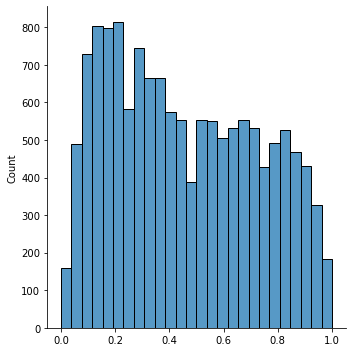

In [31]:
import seaborn as sns
sns.displot(y_pred_proba);

#### 임계값을 히스토그램에 표시해 봅시다
지금은 임계값 0.5를 기준으로 확률이 백신 접종 여부를 분류하고 있습니다.

False    8095
True     5957
dtype: int64

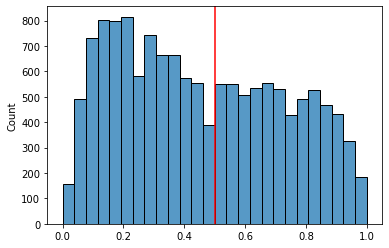

In [32]:
# Randomforestclassifier 기본 임계값은 0.5입니다.
threshold = 0.5
y_pred_proba = pipe.predict_proba(X_val)[:, 1]
y_pred = y_pred_proba > threshold

ax = sns.histplot(y_pred_proba)
ax.axvline(threshold, color='red')

pd.Series(y_pred).value_counts()

#### 임계값를 바꾸어 가며 정밀도, 재현율의 변화를 관찰해 보세요.
임계값을 낮추어 백신을 접종하지 않을 확률이 높은 사람들을 더 정확하게 구하는 것이 도움이 될 것 같습니다.

임계값을 낮추면 정밀도는 올라가지만 재현율은 떨어질 것입니다.

In [33]:
from ipywidgets import interact, fixed

def explore_threshold(y_true, y_pred_proba, threshold=0.5):
    y_pred = y_pred_proba >= threshold
    vc = pd.Series(y_pred).value_counts()
    ax = sns.histplot(y_pred_proba, kde=True)
    ax.axvline(threshold, color='red')
    ax.set_title(f'# of target, 1={vc[1]}, 0={vc[0]}')
    plt.show()
    print(classification_report(y_true, y_pred))

    
interact(explore_threshold, 
    y_true=fixed(y_val), 
    y_pred_proba=fixed(y_pred_proba), 
    threshold=(0, 1, 0.01));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

#### 예측확률을 이용해 더 정확하게 구분해 봅시다.
실제 타겟 값과 예측확률을 데이터프레임으로 만들어 같이 확인해 보겠습니다.

In [34]:
pred_proba = pd.DataFrame({
    'y_val': y_val,
    'pred_proba': y_pred_proba})
pred_proba

,y_val,pred_proba
10296,0,0.540000
3515,0,0.150000
13103,0,0.220000
31432,1,1.000000
38296,1,0.060000
...,...,...
6815,0,0.180000
34682,1,0.900000
21444,1,0.860000
19491,1,0.615405


우선 백신 접종 확률이 낮은 순서(비접종 확률이 높은 순서)로 정렬해 보겠습니다.

In [35]:
top = pred_proba.sort_values(by='pred_proba', ascending=True)[:4500]
top

,y_val,pred_proba
10271,0,0.00
25027,0,0.00
37061,0,0.00
12209,0,0.00
4718,0,0.00
...,...,...
32901,0,0.27
39458,0,0.27
28620,0,0.27
34079,0,0.27


#### 여기서 일부 주민은 접종 확률이 낮음에도 접종한 사람들 입니다. (False Negative)

In [36]:
vc = top['y_val'].value_counts()
vc

0    3850
1     650
Name: y_val, dtype: int64

이렇게 접종을 하지 않았을 3850명에게 백신을 접종할 수 있게 되어 집단 면역이 가능한 항체 보유 비율을 맞출 수 있게 될 겁니다!

In [37]:
final = real_positives + vc[0]
final

10222

In [38]:
herdImmunity

9836.4

In [39]:
final > herdImmunity

True

#### 만약 예측확률을 사용하지 않고 임계값 0.5 이하에서 무작위로 접종하였다면 집단면역기준에 부합할 수 있을까요?

In [40]:
vc_rand = pred_proba[pred_proba['pred_proba'] < 0.5].sample(4500, random_state=2)['y_val'].value_counts()
vc_rand

0    3455
1    1045
Name: y_val, dtype: int64

In [41]:
final_rand = real_positives + vc_rand[0]
final_rand

9827

In [42]:
final_rand > herdImmunity

False

#### 안타깝게도 집단면역기준에 약간 다다르지 못하게 됩니다!

예측확률과 임계값을 잘 활용하면 필요한 범주의 정밀도나 재현율을 조정하여 최소한의 백신접종으로 최대한의 결과를 거둘 수 있을것이라 예상됩니다.

이렇듯 분류문제에서 임계값을 잘 설정한다면 보다 효율적으로 문제를 해결할 수 있을텐데,

- 모든 임계값을 한 눈에 보고 모델을 평가할 수 있는 방법이 있을까요?

**ROC curve를 사용하면 됩니다!**

## ROC, AUC (Receiver Operating Characteristic, Area Under the Curve)
ROC curve, AUC를 사용하면 분류문제에서 여러 임계값 설정에 대한 모델의 성능을 구할 수 있게 됩니다. ROC curve는 여러 임계값에 대해 TPR(True Positive Rate, recall)과 FPR(False Positive Rate) 그래프를 보여줍니다.

- [Receiver operating characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)

**Recall(재현율) = Sensitivity** = ${\displaystyle \mathrm {TPR} ={\frac {\mathrm {TP} }{\mathrm {P} }}={\frac {\mathrm {TP} }{\mathrm {TP} +\mathrm {FN} }}=1-\mathrm {FNR} }$

**Fall-out(위양성률)** = ${\displaystyle \mathrm {FPR} ={\frac {\mathrm {FP} }{\mathrm {N} }}={\frac {\mathrm {FP} }{\mathrm {FP} +\mathrm {TN} }}=1-\mathrm {TNR(Specificity)} }$

- 재현율을 높이기 위해서는 Positive로 판단하는 임계값을 계속 낮추어 모두 Positive로 판단하게 만들면 됩니다. 하지만 이렇게 하면 동시에 Negative이지만 Positive로 판단하는 위양성률도 같이 높아집니다.

- 재현율은 최대화 하고 위양성률은 최소화 하는 임계값이 최적의 임계값입니다.

- **AUC** 는 **ROC curve의 아래 면적**을 말합니다.

- 아래 링크에서 두 클래스의 분포와 임계값을 변형시키며 ROC curve의 변화를 살펴 보세요

[Understanding ROC curve](http://www.navan.name/roc/)

사이킷런 roc_curve는 임계값에 따른 TPR, FPR 수치를 자동으로 계산해 줍니다.

In [43]:
from sklearn.metrics import roc_curve

# roc_curve(타겟값, prob of 1)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})
roc

,FPR(Fall-out),TPRate(Recall),Threshold
0,0.000000,0.000000,2.0000
1,0.000130,0.003766,1.0000
2,0.000391,0.009416,0.9900
3,0.000391,0.009730,0.9850
4,0.001042,0.016478,0.9800
...,...,...,...
526,0.995182,0.999215,0.0200
527,0.995313,0.999215,0.0140
528,0.995703,0.999215,0.0125
529,0.999089,1.000000,0.0100


이제 ROC curve를 그려 봅시다

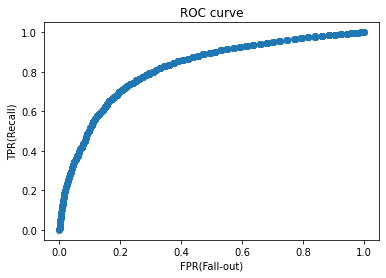

In [44]:
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

최적의 threshold를 찾아 볼까요?

In [45]:
# threshold 최대값의 인덱스, np.argmax()
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print('idx:', optimal_idx, ', threshold:', optimal_threshold)

idx: 256 , threshold: 0.4633333333333334


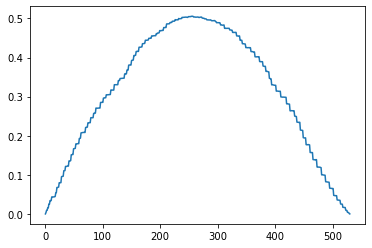

In [46]:
plt.plot(tpr-fpr);

In [47]:
y_pred_optimal = y_pred_proba >= optimal_threshold
print(classification_report(y_val, y_pred_optimal))

              precision    recall  f1-score   support

           0       0.78      0.77      0.77      7680
           1       0.73      0.74      0.73      6372

    accuracy                           0.75     14052
   macro avg       0.75      0.75      0.75     14052
weighted avg       0.75      0.75      0.75     14052



In [48]:
y_pred_optimal

array([ True, False, False, ...,  True,  True, False])

threshold 0.5 와 비교해 보겠습니다.

In [49]:
y_pred_05 = y_pred_proba >= 0.5
print(classification_report(y_val, y_pred_05))

              precision    recall  f1-score   support

           0       0.77      0.80      0.78      7680
           1       0.74      0.71      0.72      6372

    accuracy                           0.76     14052
   macro avg       0.75      0.75      0.75     14052
weighted avg       0.75      0.76      0.75     14052



이번에는 AUC점수를 계산해 보겠습니다. AUC값은 높을 수록 좋겠지요!

In [50]:
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_val, y_pred_proba)
auc_score

0.8187195526653066

ROC curve는 이진분류문제에서 사용할 수 있습니다. 다중분류문제에서는 각 클래스를 이진클래스 분류문제로 변환(One Vs All)하여 구할 수 있습니다.
- 3-class(A, B, C) 문제 -> A vs (B,C), B vs (A,C), C vs (A,B) 로 나누어 수행


분류문제에서 모델을 올바르게 평가하기 위해서는 정확도 외에도 **정밀도, 재현율** 을 잘 이해하고 사용해야 한다는 것을 알았습니다. 특히 각 범주를 예측하는 기준이 되는 임계값의 위치에 따라 정밀도나 재현율이 달라지기 때문에 문제의 상황에 따라 적절한 임계값을 선택할 필요성이 있습니다. 이진 분류문제에서는 ROC curve와 AUC 점수를 잘 활용하면 좋은 결과를 만들어낼 수 있을 것 입니다.


## 참고자료
- [Making sense of the confusion matrix
](https://youtu.be/8Oog7TXHvFY)
- [Machine Learning tips and tricks cheatsheet](https://stanford.edu/~shervine/teaching/cs-229/cheatsheet-machine-learning-tips-and-tricks)
- [Understanding AUC - ROC Curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5#:~:text=for%20multiclass%20model%3F-,What%20is%20AUC%20%2D%20ROC%20Curve%3F,capable%20of%20distinguishing%20between%20classes.)
- [ROC curves and Area Under the Curve explained](https://www.dataschool.io/roc-curves-and-auc-explained/)
- [3.3.2.14. Receiver operating characteristic (ROC)](https://scikit-learn.org/stable/modules/model_evaluation.html#receiver-operating-characteristic-roc)
- [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
- [sklearn.metrics.roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)